# Training DL models with default hyperparameters on the IDS2017

In this notebook, different DL models are used on the IDS2017 without hyperparameter optimization to test the performance. Deep neural networks, autoencoders, convolutional networks and RNNs are tested on the dataset.

In [1]:
from utils_ids2017 import load_ids2017, feature_selection
from notebook_utils import plot_confusion_matrix, metrics_report, calculate_metrics_by_label, test_metrics_DL, plot_overall_accuracy
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import numpy as np

attack_labels = {
    0: 'BENIGN',
    7: 'FTP-Patator',
    11: 'SSH-Patator',
    6: 'DoS slowloris',
    5: 'DoS Slowhttptest',
    4: 'DoS Hulk',
    3: 'DoS GoldenEye',
    8: 'Heartbleed',
    12: 'Web Attack - Brute Force',
    14: 'Web Attack - XSS',
    13: 'Web Attack - Sql Injection',
    9: 'Infiltration',
    1: 'Bot',
    10: 'PortScan',
    2: 'DDoS'
}

## Load Dataset

In [2]:
df = load_ids2017()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 96 columns):
 #   Column                       Dtype   
---  ------                       -----   
 0   destination_port             int64   
 1   protocol                     int64   
 2   flow_duration                int64   
 3   total_fwd_packets            int64   
 4   total_backward_packets       int64   
 5   total_length_of_fwd_packets  float64 
 6   total_length_of_bwd_packets  float64 
 7   fwd_packet_length_max        float64 
 8   fwd_packet_length_min        float64 
 9   fwd_packet_length_mean       float64 
 10  fwd_packet_length_std        float64 
 11  bwd_packet_length_max        float64 
 12  bwd_packet_length_min        float64 
 13  bwd_packet_length_mean       float64 
 14  bwd_packet_length_std        float64 
 15  flow_bytes_s                 float64 
 16  flow_packets_s               float64 
 17  flow_iat_mean                float64 
 18  flow_iat_std          

In [3]:
X = df.iloc[:, 0:79]
Y = df.iloc[:, 79:]
X.info()
Y.info()
print(Y.label.value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 2827876 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   destination_port             int64  
 1   protocol                     int64  
 2   flow_duration                int64  
 3   total_fwd_packets            int64  
 4   total_backward_packets       int64  
 5   total_length_of_fwd_packets  float64
 6   total_length_of_bwd_packets  float64
 7   fwd_packet_length_max        float64
 8   fwd_packet_length_min        float64
 9   fwd_packet_length_mean       float64
 10  fwd_packet_length_std        float64
 11  bwd_packet_length_max        float64
 12  bwd_packet_length_min        float64
 13  bwd_packet_length_mean       float64
 14  bwd_packet_length_std        float64
 15  flow_bytes_s                 float64
 16  flow_packets_s               float64
 17  flow_iat_mean                float64
 18  flow_iat_std                 float64
 19  flow_

## Feature Selection

In [4]:
X = feature_selection(X, Y)

                        Feature  Information Gain
1                 flow_duration          0.227608
10               flow_packets_s          0.217442
3   total_length_of_fwd_packets          0.211574
11                flow_iat_mean          0.210155
9                  flow_bytes_s          0.203778
23                bwd_packets_s          0.198501
31       init_win_bytes_forward          0.187975
4         fwd_packet_length_max          0.185553
6        fwd_packet_length_mean          0.182135
12                 flow_iat_std          0.175614
7         bwd_packet_length_max          0.162407
32      init_win_bytes_backward          0.154839
18                  bwd_iat_max          0.150704
15                bwd_iat_total          0.146838
16                 bwd_iat_mean          0.144893
21            fwd_header_length          0.139121
5         fwd_packet_length_min          0.114646
24            min_packet_length          0.108750
13                 flow_iat_min          0.107581


## Split Dataset

The dataset is split into a training set and a testing set with a ratio of 0.8/0.2. The dataset is stratified according to the label to have an equal representation of all classes in the 2 subsets.

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y.label_code)

In [6]:
Y_train.label.value_counts()

label
BENIGN                        1817055
DoS Hulk                       184099
PortScan                       127043
DDoS                           102420
DoS GoldenEye                    8234
FTP-Patator                      6348
SSH-Patator                      4717
DoS slowloris                    4637
DoS Slowhttptest                 4399
Bot                              1565
Web Attack - Brute Force         1206
Web Attack - XSS                  522
Infiltration                       29
Web Attack - Sql Injection         17
Heartbleed                          9
Name: count, dtype: int64

In [7]:
Y_test.label.value_counts()

label
BENIGN                        454265
DoS Hulk                       46025
PortScan                       31761
DDoS                           25605
DoS GoldenEye                   2059
FTP-Patator                     1587
SSH-Patator                     1180
DoS slowloris                   1159
DoS Slowhttptest                1100
Bot                              391
Web Attack - Brute Force         301
Web Attack - XSS                 130
Infiltration                       7
Web Attack - Sql Injection         4
Heartbleed                         2
Name: count, dtype: int64

Statistics

In [8]:
benign_percentage = len(Y_train.label[Y_train["label"]=="BENIGN"])/len(Y_train)
print('Percentage of benign samples: %.4f' % benign_percentage)
print(Y_train.is_attack.value_counts())

Percentage of benign samples: 0.8032
is_attack
0    1817055
1     445245
Name: count, dtype: int64


## SMOTE Resampling

In [9]:
from imblearn.over_sampling import SMOTE

def resample_dataset(X, Y, min_samples, attack_labels):
    Y = Y.drop(columns=['label'])
    combined = pd.concat([X, Y], axis=1)
    counts = Y['label_code'].value_counts()
    samples_number = {i: max(counts[i], min_samples) for i in np.unique(Y['label_code'])}
    combined_array = combined.values
    y_array = Y['label_code'].values
    resampler = SMOTE(random_state=42, sampling_strategy=samples_number)
    resampled_array, y_resampled = resampler.fit_resample(combined_array, y_array)
    X_resampled = resampled_array[:, :-Y.shape[1]]
    Y_resampled = resampled_array[:, -Y.shape[1]:]
    X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
    Y_resampled_df = pd.DataFrame(Y_resampled, columns=Y.columns)
    Y_resampled_df['label'] = Y_resampled_df['label_code'].map(attack_labels)
    Y_resampled_df['label'] = Y_resampled_df['label'].astype('category')
    return X_resampled_df, Y_resampled_df

X_smote_train, Y_smote_train = resample_dataset(X_train, Y_train, 100000, attack_labels)


In [10]:
Y_smote_train.label.value_counts()

label
BENIGN                        1817055
DoS Hulk                       184099
PortScan                       127043
DDoS                           102420
Bot                            100000
DoS GoldenEye                  100000
DoS Slowhttptest               100000
DoS slowloris                  100000
FTP-Patator                    100000
Heartbleed                     100000
Infiltration                   100000
SSH-Patator                    100000
Web Attack - Brute Force       100000
Web Attack - Sql Injection     100000
Web Attack - XSS               100000
Name: count, dtype: int64

In [11]:
from sklearn.preprocessing import StandardScaler

scaler_smote = StandardScaler()
scaler_smote.fit(X_smote_train)

StandardScaler()

In [23]:
# Save the model
def save_model(model, model_name):
    # Create directory if it does not exist
    model_dir = os.path.join("models", "DL_models_default")
    os.makedirs(model_dir, exist_ok=True)
    # Save the model
    model.save(os.path.join(model_dir, f"{model_name}.keras"))

## DNN

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, LSTM, TimeDistributed, RepeatVector, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

metrics = {}

Epoch 1/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 49s 575us/step - accuracy: 0.9402 - loss: 0.1320 - val_accuracy: 0.2342 - val_loss: 2.5985
Epoch 2/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 48s 575us/step - accuracy: 0.9595 - loss: 0.0895 - val_accuracy: 0.2015 - val_loss: 4.2200
Epoch 3/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 48s 580us/step - accuracy: 0.9624 - loss: 0.0828 - val_accuracy: 0.2987 - val_loss: 2.1751
Epoch 4/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 48s 577us/step - accuracy: 0.9641 - loss: 0.0790 - val_accuracy: 0.2816 - val_loss: 2.1998
Epoch 5/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 49s 583us/step - accuracy: 0.9651 - loss: 0.0766 - val_accuracy: 0.4343 - val_loss: 1.7533
Epoch 6/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 50s 595us/step - accuracy: 0.9659 - loss: 0.0751 - val_accuracy: 0.4202 - val_loss: 1.8055
Epoch 7/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 50s 596us/step - accuracy: 0.9667 - loss: 0.0734 - val_accuracy: 0.3183 - val_loss: 1.9461
Epoch 8/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 50s 596us/s

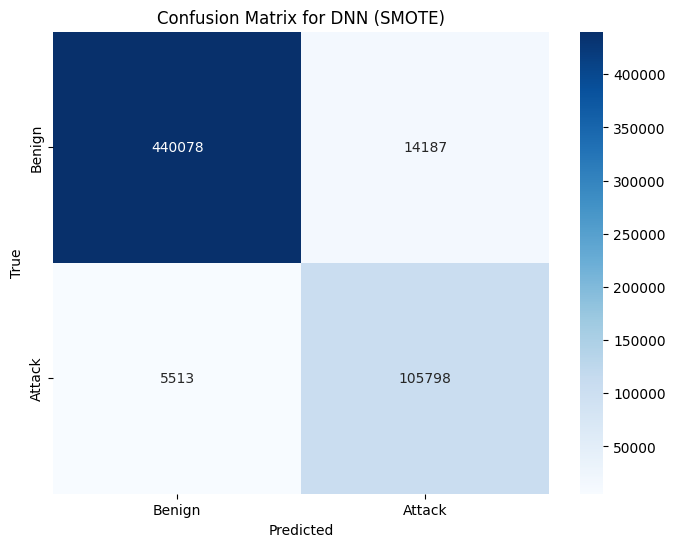

Metrics by Label (SMOTE):
                         Label  Accuracy Method
0                       BENIGN  0.968769  SMOTE
1                     DoS Hulk  0.941901  SMOTE
2                         DDoS  0.989963  SMOTE
3                     PortScan  0.953308  SMOTE
4                DoS GoldenEye  0.990287  SMOTE
5                  FTP-Patator  0.994959  SMOTE
6             DoS Slowhttptest  0.992727  SMOTE
7                  SSH-Patator  0.488136  SMOTE
8                DoS slowloris  0.993960  SMOTE
9                          Bot  0.884910  SMOTE
10    Web Attack - Brute Force  0.089701  SMOTE
11            Web Attack - XSS  0.038462  SMOTE
12  Web Attack - Sql Injection  0.500000  SMOTE
13                Infiltration  0.285714  SMOTE
14                  Heartbleed  0.500000  SMOTE


In [14]:
# Define DNN model
def create_dnn_model(input_shape):
    model = Sequential()
    model.add(Input(shape=(input_shape,)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create, train, and evaluate DNN model
dnn_model = create_dnn_model(X_smote_train.shape[1])
dnn_model.fit(scaler_smote.transform(X_smote_train), Y_smote_train.is_attack, epochs=10, batch_size=32, 
              validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

# Evaluate and save the model
metrics["DNN"] = test_metrics_DL("DNN", dnn_model, scaler_smote, X_test, Y_test, reshape=False)
save_model(dnn_model, "DNN_SMOTE")


## CNN

Epoch 1/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 71s 842us/step - accuracy: 0.9369 - loss: 0.1384 - val_accuracy: 0.3207 - val_loss: 2.8561
Epoch 2/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 69s 824us/step - accuracy: 0.9591 - loss: 0.0912 - val_accuracy: 0.3168 - val_loss: 2.6642
Epoch 3/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 69s 824us/step - accuracy: 0.9621 - loss: 0.0837 - val_accuracy: 0.3537 - val_loss: 2.8004
Epoch 4/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 69s 828us/step - accuracy: 0.9644 - loss: 0.0795 - val_accuracy: 0.3822 - val_loss: 3.4610
Epoch 5/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 66s 796us/step - accuracy: 0.9662 - loss: 0.0762 - val_accuracy: 0.4077 - val_loss: 2.1219
Epoch 6/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 66s 795us/step - accuracy: 0.9680 - loss: 0.0734 - val_accuracy: 0.3949 - val_loss: 3.1945
Epoch 7/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 67s 806us/step - accuracy: 0.9711 - loss: 0.0683 - val_accuracy: 0.2831 - val_loss: 3.1067
Epoch 8/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 67s 806us/s

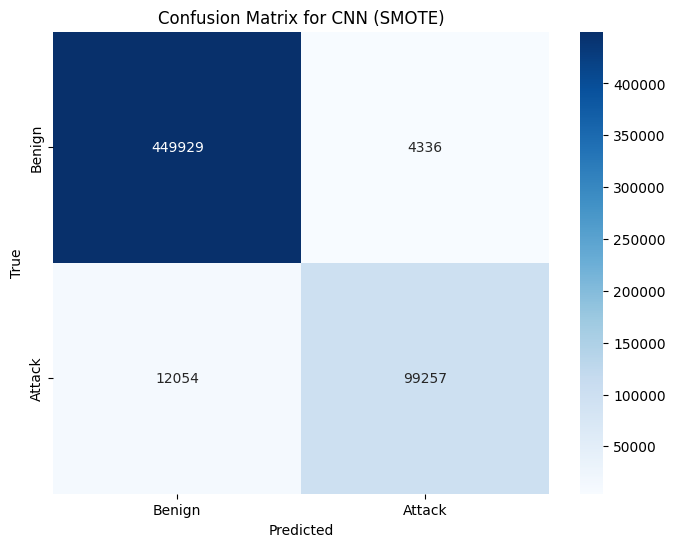

Metrics by Label (SMOTE):
                         Label  Accuracy Method
0                       BENIGN  0.990455  SMOTE
1                     DoS Hulk  0.903596  SMOTE
2                         DDoS  0.985433  SMOTE
3                     PortScan  0.806146  SMOTE
4                DoS GoldenEye  0.993201  SMOTE
5                  FTP-Patator  0.996849  SMOTE
6             DoS Slowhttptest  0.993636  SMOTE
7                  SSH-Patator  0.490678  SMOTE
8                DoS slowloris  0.995686  SMOTE
9                          Bot  0.864450  SMOTE
10    Web Attack - Brute Force  0.096346  SMOTE
11            Web Attack - XSS  0.061538  SMOTE
12  Web Attack - Sql Injection  0.500000  SMOTE
13                Infiltration  0.285714  SMOTE
14                  Heartbleed  0.500000  SMOTE


In [15]:
# Define CNN model
def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(64, kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create, train, and evaluate CNN model
cnn_model = create_cnn_model((X_smote_train.shape[1], 1))

history = cnn_model.fit(scaler_smote.transform(X_smote_train), Y_smote_train.is_attack, epochs=10, batch_size=32, 
                        validation_split=0.2, 
                        callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

# Evaluate and save the model
metrics["CNN"] = test_metrics_DL("CNN", cnn_model, scaler_smote, X_test, Y_test, reshape=False)
save_model(cnn_model, "CNN_SMOTE")


## RNN

In [17]:
# Define RNN model
def create_rnn_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(32))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create, train, and evaluate RNN model
rnn_model = create_rnn_model((X_smote_train.shape[1], 1))
rnn_model.fit(scaler_smote.transform(X_smote_train), Y_smote_train.is_attack, epochs=10, batch_size=32, 
              validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

Epoch 1/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 558s 7ms/step - accuracy: 0.9179 - loss: 0.1728 - val_accuracy: 0.2430 - val_loss: 3.5252
Epoch 2/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 544s 7ms/step - accuracy: 0.9622 - loss: 0.0837 - val_accuracy: 0.2180 - val_loss: 2.2114
Epoch 3/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 560s 7ms/step - accuracy: 0.9660 - loss: 0.0751 - val_accuracy: 0.3830 - val_loss: 1.8505
Epoch 4/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 565s 7ms/step - accuracy: 0.9682 - loss: 0.0701 - val_accuracy: 0.3049 - val_loss: 1.8628
Epoch 5/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 567s 7ms/step - accuracy: 0.9710 - loss: 0.0651 - val_accuracy: 0.3829 - val_loss: 1.5151
Epoch 6/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 554s 7ms/step - accuracy: 0.9746 - loss: 0.0590 - val_accuracy: 0.4727 - val_loss: 1.3562
Epoch 7/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 558s 7ms/step - accuracy: 0.9773 - loss: 0.0539 - val_accuracy: 0.3752 - val_loss: 1.9424
Epoch 8/10
83266/83266 ━━━━━━━━━━━━━━━━━━━━ 542s 7ms/step - ac

AttributeError: 'DataFrame' object has no attribute 'reshape'

In [ ]:
# Evaluate and save the model
metrics["RNN"] = test_metrics_DL("RNN", rnn_model, scaler_smote, X_test, Y_test, reshape=False)
save_model(rnn_model, "RNN_SMOTE")

 9913/17675 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step

## Autoencoder

In [ ]:
# Define Autoencoder model
def create_autoencoder_model(input_shape):
    model = Sequential()
    model.add(Input(shape=(input_shape,)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(input_shape, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['accuracy'])
    return model

# Create, train, and evaluate Autoencoder model
autoencoder_model = create_autoencoder_model(X_smote_train.shape[1])
autoencoder_model.fit(scaler_smote.transform(X_smote_train), scaler_smote.transform(X_smote_train), epochs=10, batch_size=32, 
                      validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])


In [ ]:
# Evaluate and save the model
metrics["RNN"] = test_metrics_DL("RNN", rnn_model, scaler_smote, X_test, Y_test, reshape=False)
save_model(rnn_model, "RNN_SMOTE")